# **Load the dataset**


Import Required Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
# Load the dataset
df = pd.read_csv('drive/MyDrive/Project_data/ecommerce_customer_data_custom_ratios.csv')

Initial Dataset Overview

In [ ]:
print(df.head())
print("Dataset Shape:", df.shape)
print(df.describe())
print("\nDataset Info:\n")
print(df.info())
print("\nMissing Values:\n", df.isnull().sum())

   Customer ID        Purchase Date Product Category  Product Price  Quantity  \
0        46251  2020-09-08 09:38:32      Electronics             12         3   
1        46251  2022-03-05 12:56:35             Home            468         4   
2        46251  2022-05-23 18:18:01             Home            288         2   
3        46251  2020-11-12 13:13:29         Clothing            196         1   
4        13593  2020-11-27 17:55:11             Home            449         1   

   Total Purchase Amount Payment Method  Customer Age  Returns  \
0                    740    Credit Card            37      0.0   
1                   2739         PayPal            37      0.0   
2                   3196         PayPal            37      0.0   
3                   3509         PayPal            37      0.0   
4                   3452    Credit Card            49      0.0   

         Customer Name  Age  Gender  Churn  
0  Christine Hernandez   37    Male      0  
1  Christine Hernandez   3

# **EDA**

     -Churn Distribution

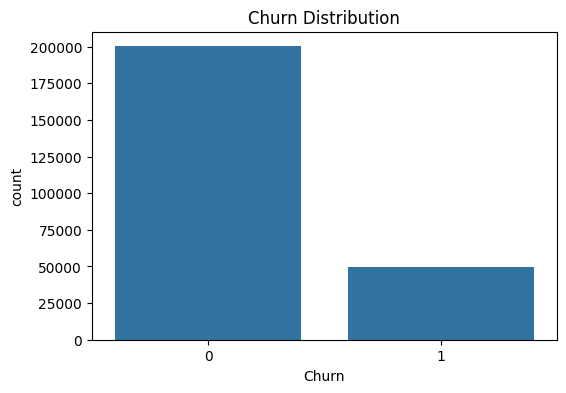

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Churn', data=df)
plt.title('Churn Distribution')
plt.show()

  -Numerical Feature Distributions

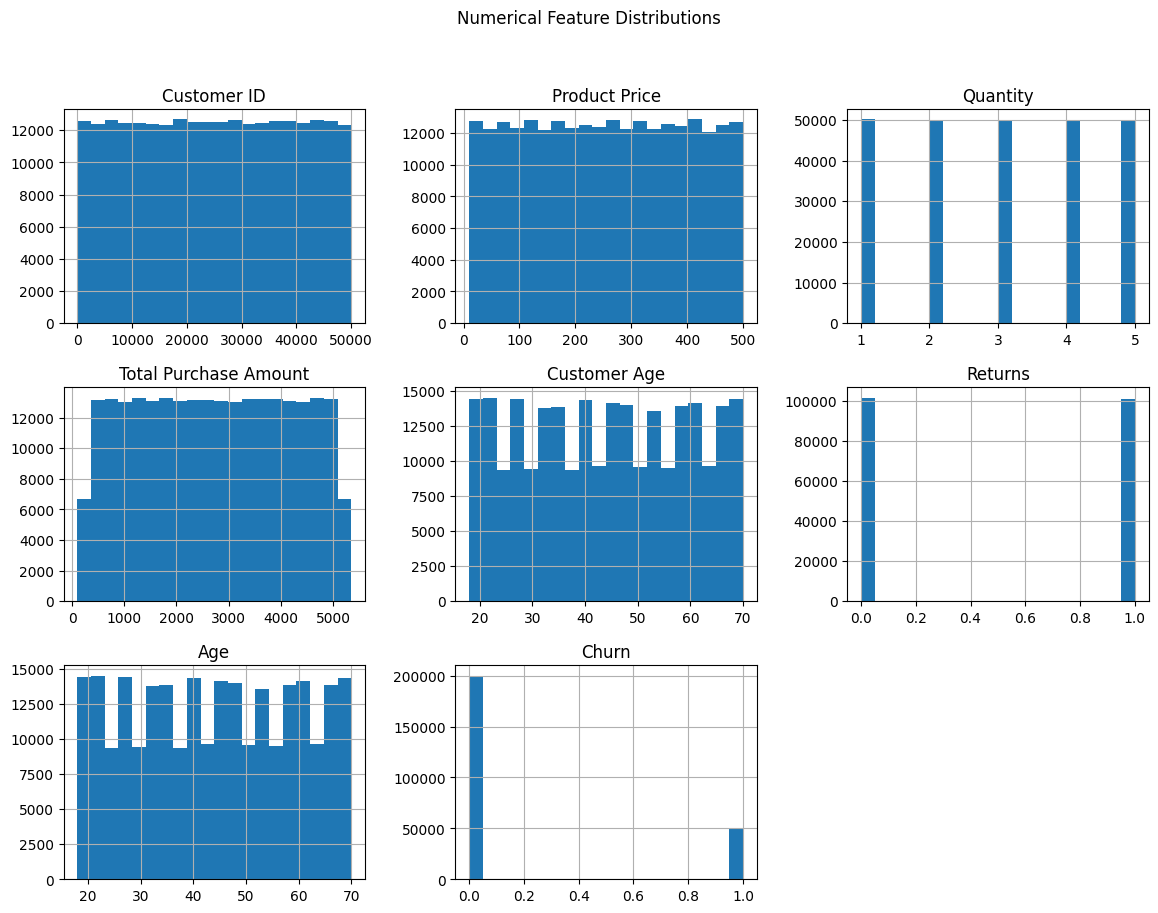

In [ ]:
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns
df[numerical_columns].hist(bins=20, figsize=(14, 10))
plt.suptitle("Numerical Feature Distributions")
plt.show()

   -categorical Feature Distributions

In [ ]:
for col in df.select_dtypes(include=['object']).columns:
    print(f"{col}: {df[col].nunique()} unique values")

Purchase Date: 249736 unique values
Product Category: 4 unique values
Payment Method: 4 unique values
Customer Name: 39920 unique values
Gender: 2 unique values


# **FEATURE ENGINEERING**

In [ ]:
# Feature Engineering

# 1. Total Spend
# Summing up all purchase amounts for each customer
df['total_spend'] = df.groupby('Customer ID')['Total Purchase Amount'].transform('sum')

# 2. Frequency of Purchase
# Counting the number of purchases for each customer
df['purchase_frequency'] = df.groupby('Customer ID')['Purchase Date'].transform('count')

# 3. Time Since Last Purchase
# Convert 'purchase_date' to datetime if not already in datetime format
df['Purchase Date'] = pd.to_datetime(df['Purchase Date'])

# Sort by 'Customer ID' and 'Purchase Date'
df = df.sort_values(by=['Customer ID', 'Purchase Date'])

# Calculate the time difference between consecutive purchases
df['time_diff'] = df.groupby('Customer ID')['Purchase Date'].diff().dt.days

# Calculate the average time between purchases for each customer
df['days_since_last_purchase'] = df.groupby('Customer ID')['time_diff'].transform('mean')

# 4. Extract Time Features
# Extract day of the week, hour, and month from 'Purchase Date'
df['purchase_day'] = df['Purchase Date'].dt.day_name()  # Day of the week (e.g., Monday)
df['purchase_hour'] = df['Purchase Date'].dt.hour       # Hour of the day (0-23)
df['purchase_month'] = df['Purchase Date'].dt.month     # Month (1-12)

# 5. Encode Gender
# Map 'Gender' to numeric values (0 for Male, 1 for Female)
df['gender_encoded'] = df['Gender'].map({'Male': 0, 'Female': 1})

# 6. Drop Irrelevant Columns
# Note: Not droping ID as it will used as an index for clustering or analysis later
df = df.drop(columns=['Customer Name'])
df = df.drop(columns=['Customer Age'])
# Display the updated dataset
df.head()


,Customer ID,Purchase Date,Product Category,Product Price,Quantity,Total Purchase Amount,Payment Method,Returns,Age,Gender,Churn,total_spend,purchase_frequency,time_diff,days_since_last_purchase,purchase_day,purchase_hour,purchase_month,gender_encoded
151166,1,2023-07-19 19:09:20,Books,169,5,3491,PayPal,1.0,70,Male,0,3491,1,NaN,NaN,Wednesday,19,7,0
244416,2,2021-03-05 14:30:42,Books,144,1,4210,PayPal,1.0,27,Female,0,7988,3,NaN,312.500000,Friday,14,3,1
244417,2,2021-09-19 16:55:21,Books,98,4,959,PayPal,NaN,27,Female,0,7988,3,198.0,312.500000,Sunday,16,9,1
244418,2,2022-11-21 06:48:05,Electronics,178,3,2819,PayPal,0.0,27,Female,0,7988,3,427.0,312.500000,Monday,6,11,1
231817,3,2020-09-27 22:26:24,Electronics,402,2,445,Credit Card,0.0,23,Female,0,22587,8,NaN,141.285714,Sunday,22,9,1


In [ ]:
print("Dataset Shape:", df.shape)
print(df.describe())
print("\nDataset Info:\n")
print(df.info())
print("\nMissing Values:\n", df.isnull().sum())

Dataset Shape: (250000, 19)
        Customer ID                  Purchase Date  Product Price  \
count  250000.00000                         250000  250000.000000   
mean    25004.03624  2021-11-06 23:31:24.372304128     254.659512   
min         1.00000            2020-01-01 00:15:00      10.000000   
25%     12497.75000  2020-12-02 19:33:23.249999872     132.000000   
50%     25018.00000            2021-11-06 13:10:59     255.000000   
75%     37506.00000  2022-10-11 03:42:32.750000128     377.000000   
max     50000.00000            2023-09-15 12:24:08     500.000000   
std     14428.27959                            NaN     141.568577   

            Quantity  Total Purchase Amount        Returns            Age  \
count  250000.000000          250000.000000  202404.000000  250000.000000   
mean        2.998896            2725.370732       0.497861      43.940528   
min         1.000000             100.000000       0.000000      18.000000   
25%         2.000000            1477.00000

**Convert Object Data to Numerical**

In [ ]:
from sklearn.preprocessing import LabelEncoder

# 1. Clean and Encode Gender
df['Gender'] = df['Gender'].str.strip().str.capitalize()  # Clean data
le = LabelEncoder()
df['Gender'] = le.fit_transform(df['Gender'])  # Male -> 0, Female -> 1

from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
le_product = LabelEncoder()
le_payment = LabelEncoder()

# Apply Label Encoding to Product Category
df['Product Category'] = le_product.fit_transform(df['Product Category'])

# Apply Label Encoding to Payment Method
df['Payment Method'] = le_payment.fit_transform(df['Payment Method'])

# Check the mappings
print("Product Category Mapping:", dict(zip(le_product.classes_, le_product.transform(le_product.classes_))))
print("Payment Method Mapping:", dict(zip(le_payment.classes_, le_payment.transform(le_payment.classes_))))

# Display the updated DataFrame
df.head()


# Ordinal Encoding for purchase_day
day_mapping = {'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3,
               'Friday': 4, 'Saturday': 5, 'Sunday': 6}

df['purchase_day'] = df['purchase_day'].map(day_mapping)



Product Category Mapping: {'Books': 0, 'Clothing': 1, 'Electronics': 2, 'Home': 3}
Payment Method Mapping: {'Cash': 0, 'Credit Card': 1, 'Crypto': 2, 'PayPal': 3}


In [ ]:
df.head()

,Customer ID,Purchase Date,Product Category,Product Price,Quantity,Total Purchase Amount,Payment Method,Returns,Age,Gender,Churn,total_spend,purchase_frequency,time_diff,days_since_last_purchase,purchase_day,purchase_hour,purchase_month,gender_encoded
151166,1,2023-07-19 19:09:20,0,169,5,3491,3,1.0,70,1,0,3491,1,NaN,NaN,2,19,7,0
244416,2,2021-03-05 14:30:42,0,144,1,4210,3,1.0,27,0,0,7988,3,NaN,312.500000,4,14,3,1
244417,2,2021-09-19 16:55:21,0,98,4,959,3,NaN,27,0,0,7988,3,198.0,312.500000,6,16,9,1
244418,2,2022-11-21 06:48:05,2,178,3,2819,3,0.0,27,0,0,7988,3,427.0,312.500000,0,6,11,1
231817,3,2020-09-27 22:26:24,2,402,2,445,1,0.0,23,0,0,22587,8,NaN,141.285714,6,22,9,1


**Handle Missing Values**

In [ ]:
# Handle missing values in 'Returns'
df['Returns'] = df['Returns'].fillna(0)

# Handle missing values in 'time_diff'
df['time_diff'] = df['time_diff'].fillna(-1)

# Handle missing values in 'days_since_last_purchase'
max_days = df['days_since_last_purchase'].max()  # Use max value as replacement
df['days_since_last_purchase'] = df['days_since_last_purchase'].fillna(max_days)


In [ ]:
# Select numerical columns
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns

# Inspect these columns to decide if they need scaling
print("Numerical columns to consider for scaling:", numerical_columns)


Numerical columns to consider for scaling: Index(['Customer ID', 'Product Category', 'Product Price', 'Quantity',
       'Total Purchase Amount', 'Payment Method', 'Returns', 'Age', 'Gender',
       'Churn', 'total_spend', 'purchase_frequency', 'time_diff',
       'days_since_last_purchase', 'purchase_day', 'gender_encoded'],
      dtype='object')


In [ ]:
df = df.drop(columns=['Gender'])

**Return Rate**

In [ ]:

if 'Customer ID' in df.columns and 'Returns' in df.columns:
    # Calculate total returns for each customer
    total_returns = df.groupby('Customer ID')['Returns'].sum()

    # Calculate total purchases for each customer
    total_purchases = df.groupby('Customer ID')['Customer ID'].count()

    # Calculate return rate
    return_rate = total_returns / total_purchases

    # Merge return rate back to the main DataFrame
    df = df.merge(return_rate.rename('return_rate'), on='Customer ID', how='left')

    # Replace NaN values with 0 (e.g., customers with no purchases or returns)
    df['return_rate'].fillna(0, inplace=True)

# Display first few rows to verify
print(df[['Customer ID', 'Returns', 'return_rate']].head())


   Customer ID  Returns  return_rate
0            1      1.0     1.000000
1            2      1.0     0.333333
2            2      0.0     0.333333
3            2      0.0     0.333333
4            3      0.0     0.375000


<ipython-input-14-c19bc602c878>:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['return_rate'].fillna(0, inplace=True)


# **Scaling**

In [ ]:
from sklearn.preprocessing import StandardScaler

# Columns to scale
numerical_columns_to_scale = ['total_spend', 'purchase_frequency', 'time_diff', 'days_since_last_purchase', 'Age', 'return_rate', 'Product Category', 'Payment Method' ]

# Initialize the scaler
scaler = StandardScaler()

# Apply scaling
df[numerical_columns_to_scale] = scaler.fit_transform(df[numerical_columns_to_scale])

# Verify the scaling
df[numerical_columns_to_scale].describe()

,total_spend,purchase_frequency,time_diff,days_since_last_purchase,Age,return_rate,Product Category,Payment Method
count,2.500000e+05,2.500000e+05,2.500000e+05,2.500000e+05,2.500000e+05,2.500000e+05,2.500000e+05,2.500000e+05
mean,-7.787548e-18,-1.036256e-16,2.922462e-17,5.172751e-17,-3.296918e-17,4.189360e-17,5.286438e-18,5.269385e-17
std,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00
min,-2.303984e+00,-2.238598e+00,-8.656123e-01,-1.499027e+00,-1.689913e+00,-1.845764e+00,-1.182674e+00,-1.341234e+00
25%,-7.232060e-01,-8.954908e-01,-7.871982e-01,-5.172978e-01,-8.430193e-01,-7.009648e-01,-1.182674e+00,-4.460348e-01
50%,-9.509337e-02,-8.595886e-05,-3.323961e-01,-2.362045e-01,3.874343e-03,-1.408560e-02,-2.728547e-01,-4.460348e-01
75%,6.286262e-01,4.476164e-01,4.256073e-01,1.971140e-01,8.507680e-01,4.438339e-01,6.369643e-01,1.344364e+00
max,5.530259e+00,4.924640e+00,6.108019e+00,7.535008e+00,1.697662e+00,2.733431e+00,1.546783e+00,1.344364e+00


# **Model building**

In [ ]:
from sklearn.model_selection import train_test_split

# Select the features and target
X = df[['Age', 'purchase_frequency', 'total_spend', 'time_diff', 'return_rate',
        'days_since_last_purchase', 'gender_encoded',  'Product Category', 'Payment Method']]
y = df['Churn']  # Assuming 'churn' is your target variable

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.ensemble import RandomForestClassifier

# # Define the hyperparameter grid
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [10, 20, 30, None],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'bootstrap': [True, False]
# }

# # Initialize the RandomForestClassifier
# rf = RandomForestClassifier(class_weight='balanced', random_state=42)

# # Perform grid search with cross-validation
# grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
#                            cv=5, n_jobs=-1, verbose=2, scoring='roc_auc')

# # Fit the grid search to the data
# grid_search.fit(X_train, y_train)

# # Get the best hyperparameters
# print(f"Best Hyperparameters: {grid_search.best_params_}")

# # Use the best estimator to make predictions
# best_model = grid_search.best_estimator_


In [ ]:
from sklearn.model_selection import train_test_split

# Sample 30% of the training data with stratification
X_sample, _, y_sample, _ = train_test_split(
    X_train, y_train, test_size=0.7, stratify=y_train, random_state=42
)

print(f"Sample size: {X_sample.shape[0]} rows")


Sample size: 60000 rows


In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees
    'max_depth': [10, 20, None],      # Depth of the trees
    'min_samples_split': [2, 5, 10],  # Minimum samples to split a node
    'min_samples_leaf': [1, 2, 4],    # Minimum samples at a leaf node
    'bootstrap': [True, False]        # Sampling method
}


In [ ]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import GridSearchCV

# # Initialize Random Forest model
# rf = RandomForestClassifier(random_state=42, class_weight='balanced')

# # Initialize GridSearchCV
# grid_search = GridSearchCV(
#     estimator=rf,
#     param_grid=param_grid,
#     cv=5,
#     scoring='roc_auc',   # Optimize for ROC-AUC
#     n_jobs=-1            # Use all CPU cores
# )

# # Fit GridSearchCV on the sampled data
# grid_search.fit(X_sample, y_sample)

# # Print the best parameters and best score
# print("Best Hyperparameters:", grid_search.best_params_)
# print("Best ROC-AUC Score:", grid_search.best_score_)


In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Train the final model with best hyperparameters
rf_final = RandomForestClassifier(
    bootstrap=False,
    max_depth=None,
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=300,
    random_state=42,
    class_weight='balanced'
)

rf_final.fit(X_train, y_train)


RandomForestClassifier(bootstrap=False, class_weight='balanced',
                       n_estimators=300, random_state=42)

# **Evaluation**

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score, accuracy_score, classification_report, auc

# Predict probabilities and labels
y_pred_proba = rf_final.predict_proba(X_test)[:, 1]
y_pred = rf_final.predict(X_test)

# Calculate metrics
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC on Test Data: {roc_auc:.4f}")

# Classification report
print(classification_report(y_test, y_pred))


ROC-AUC on Test Data: 0.9952
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     39920
           1       0.99      0.78      0.87     10080

    accuracy                           0.95     50000
   macro avg       0.97      0.89      0.92     50000
weighted avg       0.96      0.95      0.95     50000



Accuracy: 0.9545


<Figure size 800x600 with 0 Axes>

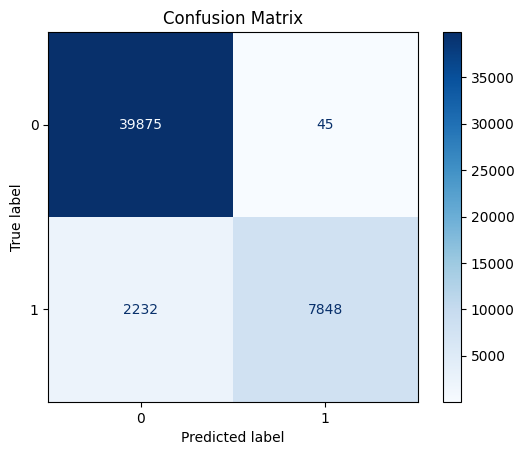

In [ ]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.4f}")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_final.classes_)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()


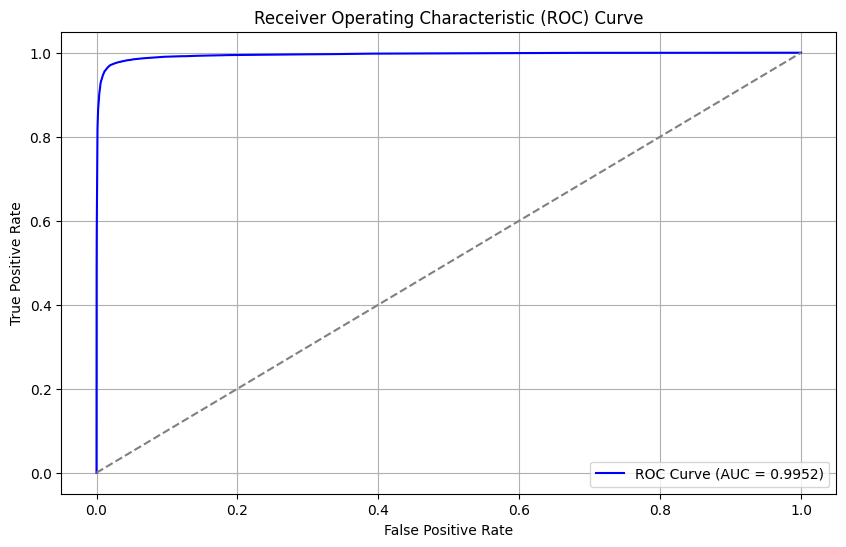

In [ ]:
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line for random guess
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()


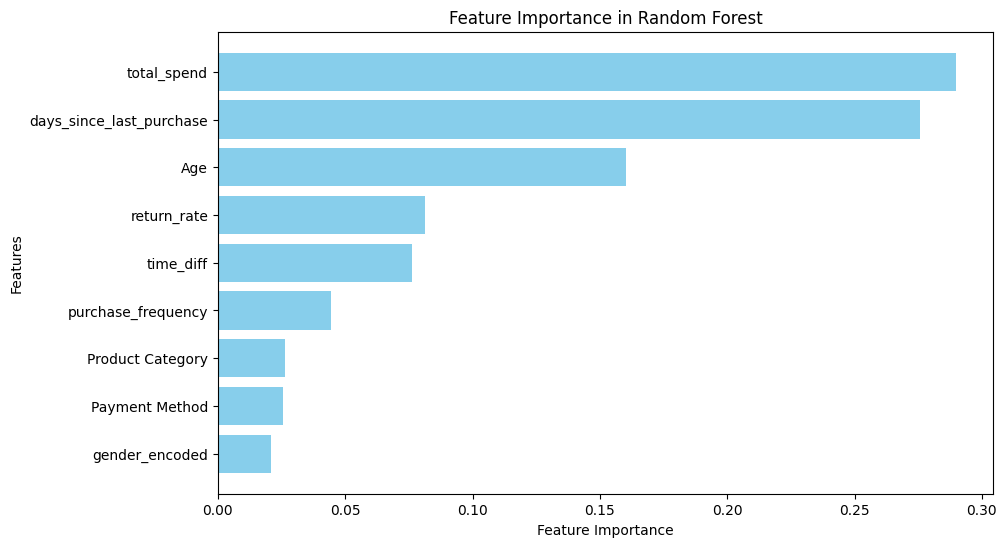

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Extract feature importance
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_final.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance in Random Forest')
plt.gca().invert_yaxis()
plt.show()


**ReEvaluation**

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Threshold adjustment code
thresholds = np.arange(0.1, 0.9, 0.1)
for t in thresholds:
    y_pred_t = (y_pred_proba >= t).astype(int)
    precision = precision_score(y_test, y_pred_t)
    recall = recall_score(y_test, y_pred_t)
    f1 = f1_score(y_test, y_pred_t)
    print(f"Threshold: {t:.2f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}")


Threshold: 0.10 | Precision: 0.4812 | Recall: 0.9957 | F1: 0.6488
Threshold: 0.20 | Precision: 0.8201 | Recall: 0.9847 | F1: 0.8949
Threshold: 0.30 | Precision: 0.9562 | Recall: 0.9552 | F1: 0.9557
Threshold: 0.40 | Precision: 0.9848 | Recall: 0.8897 | F1: 0.9348
Threshold: 0.50 | Precision: 0.9943 | Recall: 0.7829 | F1: 0.8761
Threshold: 0.60 | Precision: 0.9964 | Recall: 0.6385 | F1: 0.7783
Threshold: 0.70 | Precision: 0.9987 | Recall: 0.4637 | F1: 0.6333
Threshold: 0.80 | Precision: 0.9990 | Recall: 0.2960 | F1: 0.4567


Accuracy: 0.9820


<Figure size 800x600 with 0 Axes>

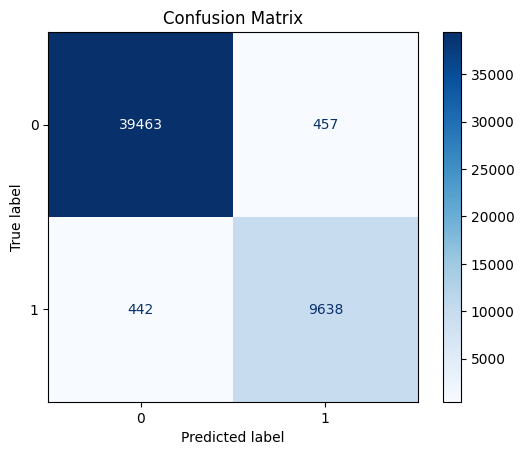


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     39920
           1       0.95      0.96      0.96     10080

    accuracy                           0.98     50000
   macro avg       0.97      0.97      0.97     50000
weighted avg       0.98      0.98      0.98     50000


Accuracy: 0.9820


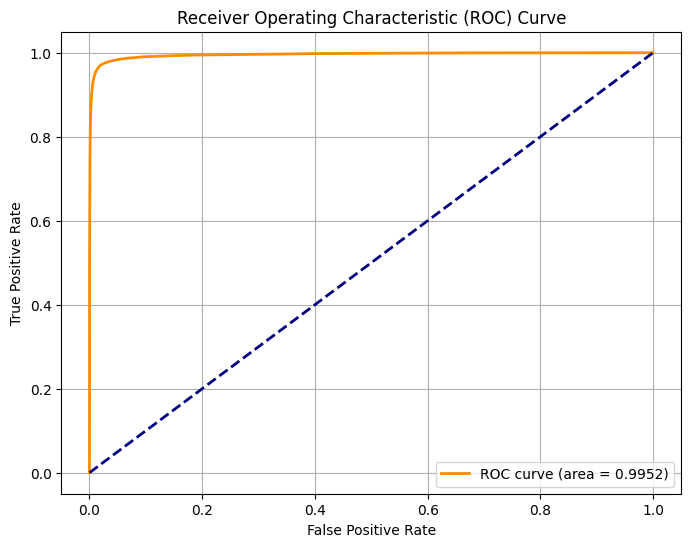

In [ ]:

# Set the chosen threshold
threshold = 0.30

# Generate predictions based on the chosen threshold
y_pred_new = (y_pred_proba >= threshold).astype(int)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_new)
acc = accuracy_score(y_test, y_pred_new)
print(f"Accuracy: {acc:.4f}")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_final.classes_)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()


print("\nClassification Report:")
print(classification_report(y_test, y_pred_new))

# Accuracy
accuracy = accuracy_score(y_test, y_pred_new)
print(f"\nAccuracy: {accuracy:.4f}")

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (area = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()
